In [1]:
!pip install tensorflow opencv-python


In [2]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Input,
    Flatten,
    Dropout,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    LayerNormalization,
    Embedding,
    MultiHeadAttention,
    UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
dataset_path = "/content/drive/MyDrive/MRIDataset"

train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

width, height = 224, 224
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode="categorical"
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


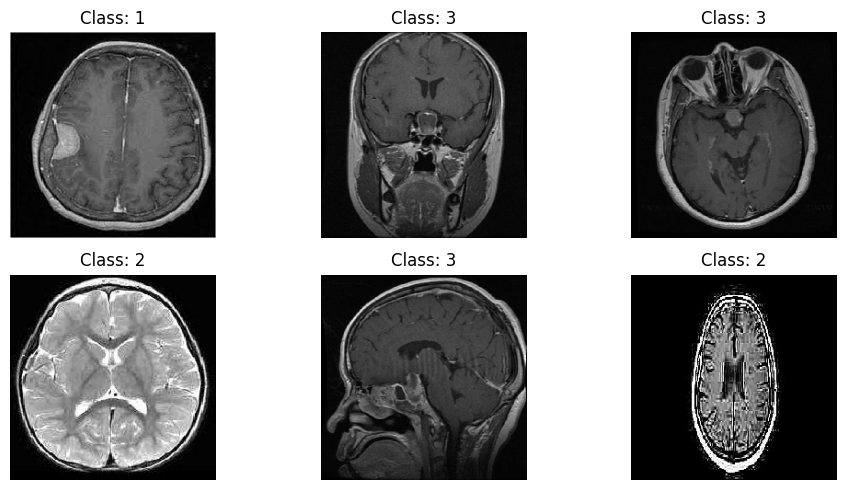

In [7]:
x_batch, y_batch = next(train_dataset)

plt.figure(figsize=(10, 5))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])  # Display the i-th image.
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis("off")  # Hide the axis ticks.

plt.tight_layout()
plt.show()


In [8]:
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [9]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

In [10]:
def transformer_block(inputs, num_heads, projection_dim, dropout_rate=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
    x = tf.keras.layers.Add()([attention_output, inputs])

    x1 = LayerNormalization(epsilon=1e-6)(x)
    x1 = Dense(units=projection_dim * 2, activation='relu')(x1)
    x1 = Dense(units=projection_dim)(x1)
    x = tf.keras.layers.Add()([x, x1])
    return x

In [11]:
def build_vit_classifier(input_shape=(width, height, 3), patch_size=32,
                         num_layers=8, num_heads=4, projection_dim=64,
                         mlp_head_units=[128]):
    inputs = Input(shape=input_shape)

    patch_extractor = PatchExtractor(patch_size)
    patches = patch_extractor(inputs)

    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    patch_encoder = PatchEncoder(num_patches, projection_dim)
    encoded_patches = patch_encoder(patches)

    for _ in range(num_layers):
        encoded_patches = transformer_block(encoded_patches, num_heads, projection_dim)

    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)

    for units in mlp_head_units:
        representation = Dense(units, activation='relu')(representation)
        representation = Dropout(0.1)(representation)

    outputs = Dense(4, activation='softmax')(representation)

    model = Model(inputs=inputs, outputs=outputs, name="ViT_Classifier")
    return model

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [13]:
def build_efficientnet_classifier(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_shape=input_shape,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze full model initially

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name="EfficientNet_Improved")
    return model


In [14]:
import cv2
from skimage.filters import threshold_otsu
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
def create_segmentation_mask(image):
    image_uint8 = (image * 255).astype(np.uint8)
    if image_uint8.shape[-1] == 3:
        gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_uint8
    thresh = threshold_otsu(gray)
    mask = gray > thresh
    return mask.astype(np.float32)

def segmentation_generator(image_generator):
    while True:
        images, _ = next(image_generator)
        masks = np.array([create_segmentation_mask(img) for img in images])
        masks = np.expand_dims(masks, axis=-1)
        yield images, masks

In [15]:
def build_unet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2D(32, (2, 2), activation='relu', padding='same')(u4)
    m4 = Concatenate()([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(m4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2D(16, (2, 2), activation='relu', padding='same')(u5)
    m5 = Concatenate()([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(m5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs, name="Fast_U_Net")
    return model

In [16]:
vit_model = build_vit_classifier()

eff_model = build_efficientnet_classifier()

unet_model = build_unet_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
vit_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [18]:
eff_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [19]:
unet_model = build_unet_model()

unet_model.summary()

Model: "Fast_U_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 224, 224,  │        448 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 224, 224,  │          0 │ conv2d_13[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 224, 224,  │      2,320 │ dropout_15[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 112, 112,  │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 112, 112,  │      9,248 │ dropout_16[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 56, 56,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 56, 56,    │          0 │ conv2d_17[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 56, 56,    │     36,928 │ dropout_17[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 112, 112,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 112, 112,  │      8,224 │ up_sampling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 112, 112,  │          0 │ conv2d_19[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 112, 112,  │     18,464 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 112, 112,  │          0 │ conv2d_20[0][0] 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)

In [21]:
history_vit = vit_model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[earlyStopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2303s 13s/step - accuracy: 0.5753 - loss: 1.0191 - val_accuracy: 0.7040 - val_loss: 0.7294
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - accuracy: 0.8272 - loss: 0.4875 - val_accuracy: 0.8223 - val_loss: 0.4657
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.8863 - loss: 0.3166 - val_accuracy: 0.8383 - val_loss: 0.3982
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.9099 - loss: 0.2479 - val_accuracy: 0.8650 - val_loss: 0.3578
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.9250 - loss: 0.2114 - val_accuracy: 0.8978 - val_loss: 0.2854
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.9458 - loss: 0.1545 - val_accuracy: 0.9077 - val_loss: 0.2347
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.9622 - loss: 0.1246 - val_accuracy: 0.9237 - val_loss: 0.2292
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.9730 - loss: 0

In [24]:
history_eff = eff_model.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.2739 - loss: 1.3818 - val_accuracy: 0.2395 - val_loss: 1.3834
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.2919 - loss: 1.3803 - val_accuracy: 0.3089 - val_loss: 1.3712
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.2866 - loss: 1.3824 - val_accuracy: 0.3074 - val_loss: 1.3745
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.2879 - loss: 1.3791 - val_accuracy: 0.3234 - val_loss: 1.3780
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.2890 - loss: 1.3790 - val_accuracy: 0.4005 - val_loss: 1.3745
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.2977 - loss: 1.3783 - val_accuracy: 0.2548 - val_loss: 1.3833
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 186ms/step - accuracy: 0.2749 - loss: 1.3814 - val_accuracy: 0.2563 - val_loss: 1.3797
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.2986 - loss: 1

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 436ms/step - accuracy: 0.8556 - loss: 0.5294 - val_accuracy: 0.8890 - val_loss: 0.5431
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 754ms/step - accuracy: 0.9134 - loss: 0.3190 - val_accuracy: 0.9120 - val_loss: 0.2182
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - accuracy: 0.9240 - loss: 0.1932 - val_accuracy: 0.9203 - val_loss: 0.1998
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - accuracy: 0.9309 - loss: 0.1734 - val_accuracy: 0.9225 - val_loss: 0.1926
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.9370 - loss: 0.1594 - val_accuracy: 0.9333 - val_loss: 0.1720
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.9385 - loss: 0.1561 - val_accuracy: 0.9342 - val_loss: 0.1693
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step - accuracy: 0.9434 - loss: 0.1447 - val_accuracy: 0.9365 - val_loss: 0.1645
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.9439 - loss: 0

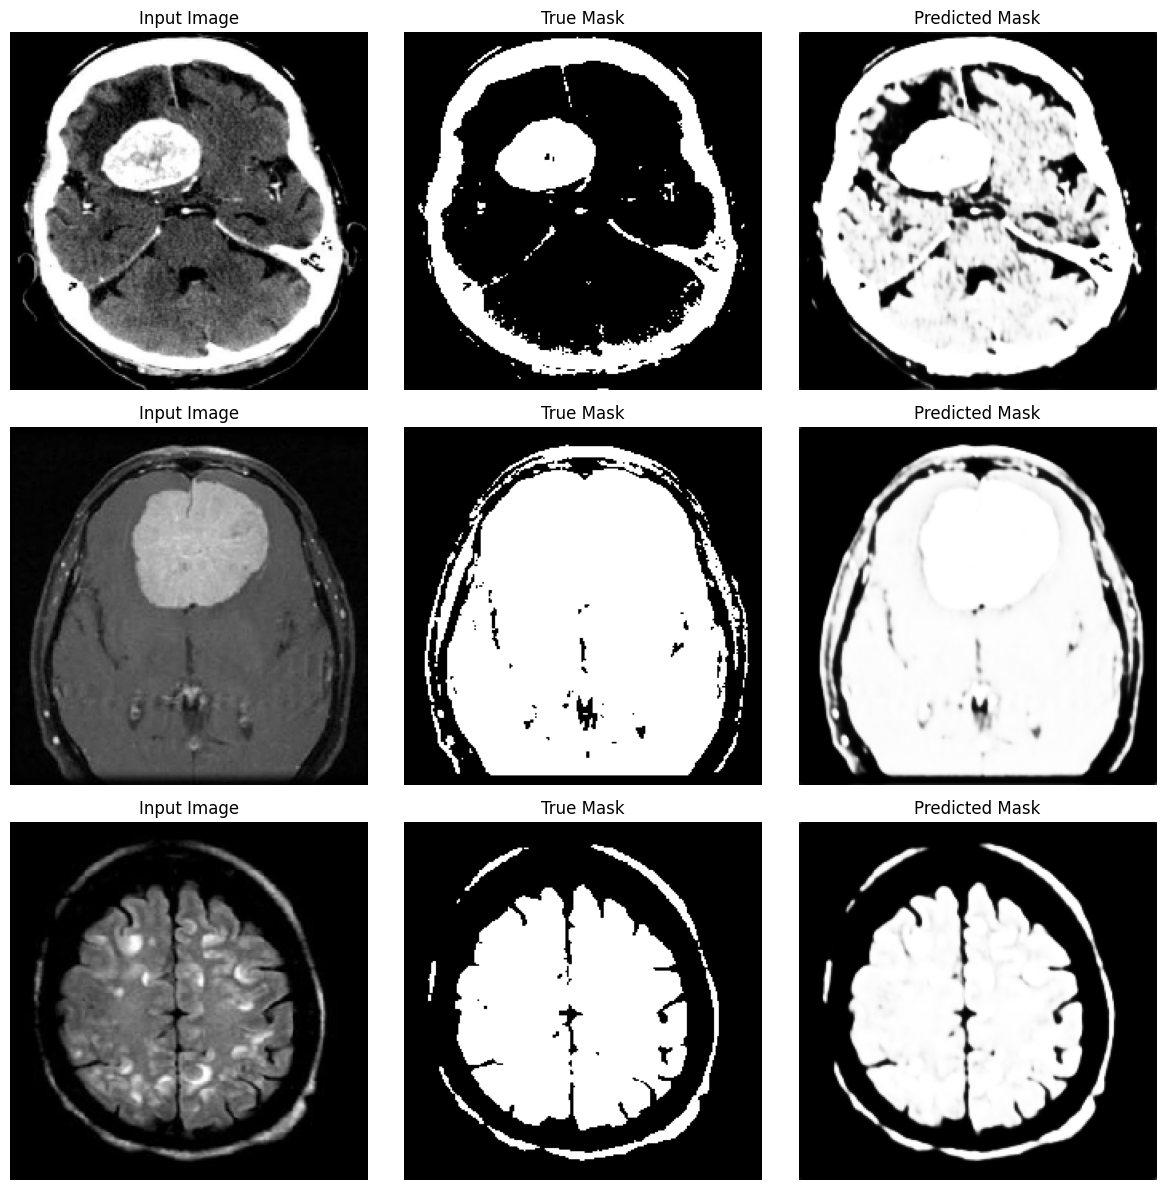

In [25]:
train_segmentation_generator = segmentation_generator(train_dataset)
val_segmentation_generator = segmentation_generator(test_dataset)

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_unet = unet_model.fit(
    train_segmentation_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_steps=100,
    validation_data=val_segmentation_generator,
    callbacks=[earlyStopping]
)

x_seg, y_seg = next(val_segmentation_generator)

pred_masks = unet_model.predict(x_seg)

n = 3

plt.figure(figsize=(12, 4 * n))

for i in range(n):
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_seg[i])
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(y_seg[i].squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_unet.history['accuracy'], label='Train Accuracy')
plt.plot(history_unet.history['val_accuracy'], label='Val Accuracy')
plt.title('U-Net Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_unet.history['loss'], label='Train Loss')
plt.plot(history_unet.history['val_loss'], label='Val Loss')
plt.title('U-Net Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

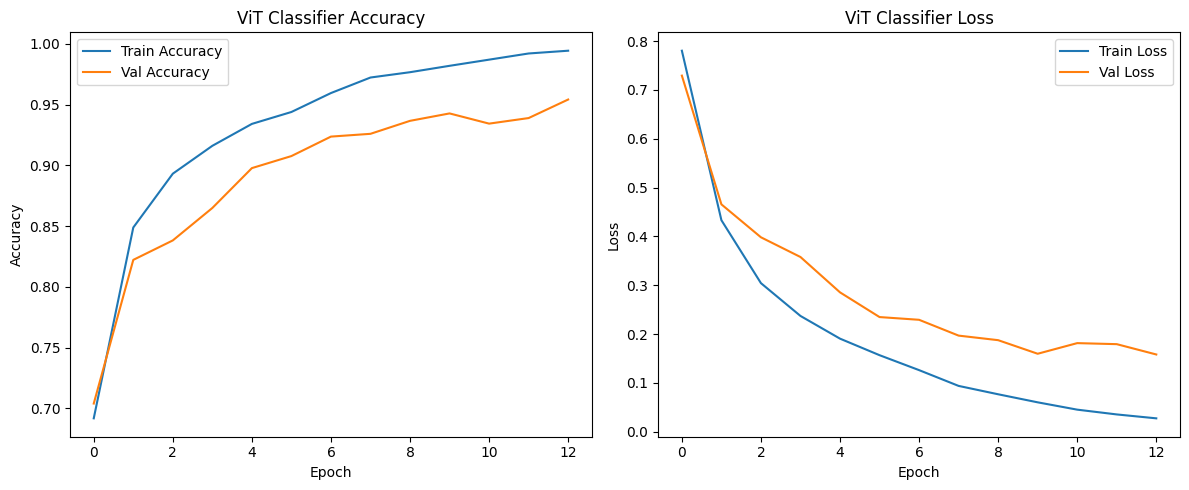

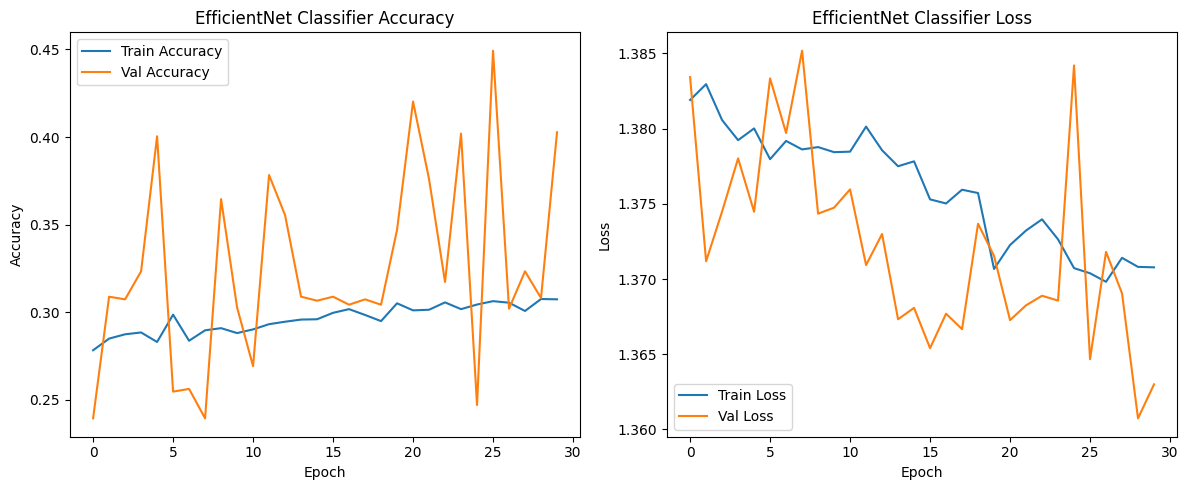

In [26]:
def plot_history(history, title_prefix="Model"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_vit, title_prefix="ViT Classifier")

plot_history(history_eff, title_prefix="EfficientNet Classifier")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


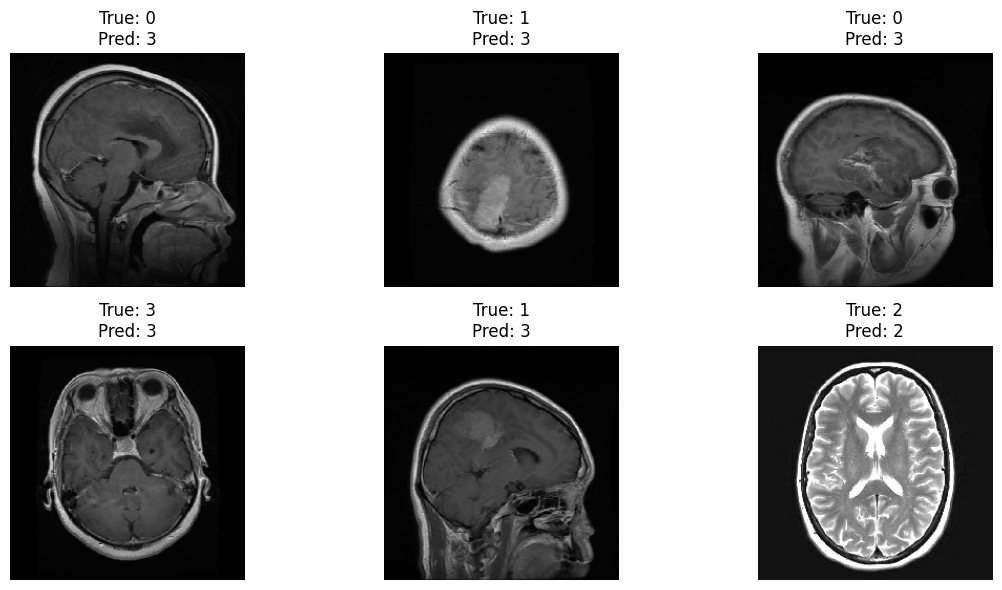

In [27]:
x_test, y_test = next(test_dataset)

preds_eff = eff_model.predict(x_test)

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(preds_eff[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


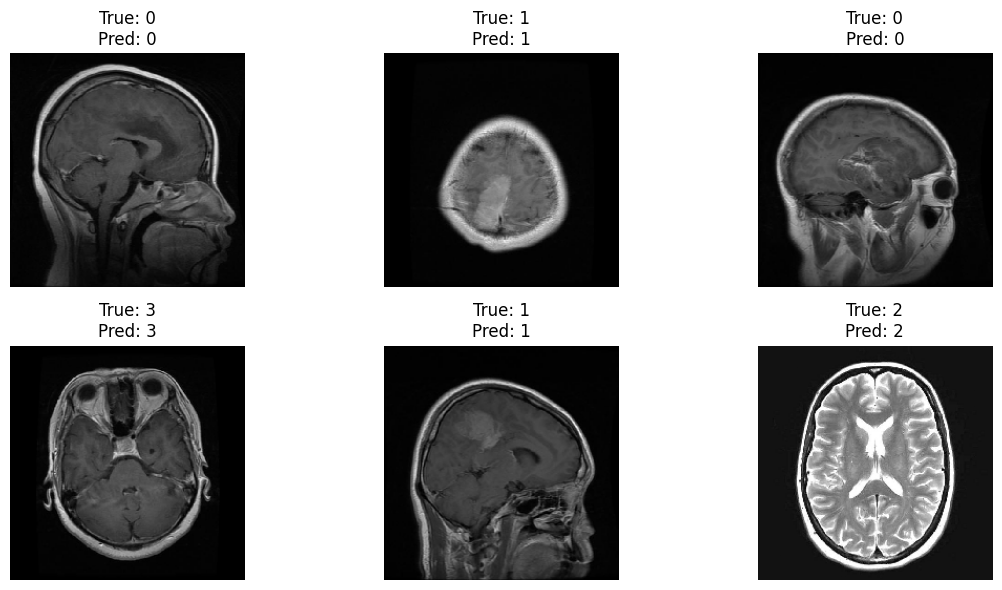

In [28]:
preds_vit = vit_model.predict(x_test)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(preds_vit[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()